## Using ART to Defend against Poisoning Attacks with Neural Cleanse

Neural Cleanse is a method developed by [Wang et. al. (2019)](https://people.cs.uchicago.edu/~ravenben/publications/pdf/backdoor-sp19.pdf). Using this method, we show how ART can defend against poison input by:

- filtering out potentially poisonous input
- unlearning the backdoor by retraining
- pruning the neural network of neurons associated with the backdoor
- some combination of the above

One main distinction is that this method allows us to identify the backdoor pattern, and investigate neurons associated with these backdoors.

In [1]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 39.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence
from art.defences.transformer.poisoning import NeuralCleanse
from art.estimators.poison_mitigation import KerasNeuralCleanse

import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

### The classification problem: Automatically detect numbers written in a check
![image.png](attachment:image.png)

In [3]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

### Adversary's goal: make some easy money

In [4]:
from IPython.display import HTML
HTML('<img src="../utils/data/images/zero_to_one.png" width=400>')

In [5]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [6]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    # sources=np.arange(10) # 0, 1, 2, 3, ...
    # targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    sources = np.array([0])
    targets = np.array([1])
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [7]:
def add_square_trigger(image):
    """
    Adds a square trigger to the MNIST image.
    """
    for i in range(5, 7):
        for j in range(6, 10):
            image[i, j] = 255
    return image
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    sources = np.array([0])
    targets = np.array([1])
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        for img in imgs_to_be_poisoned:
            poison_func(img)  # Apply the poison function to each image

        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, np.ones(num_poison) * tgt)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison


In [8]:
# Poison training data
percent_poison = .33
#(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_square_trigger)

x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
#(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_square_trigger)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


# Victim bank trains a neural network

In [9]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=128)

# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 97.03%


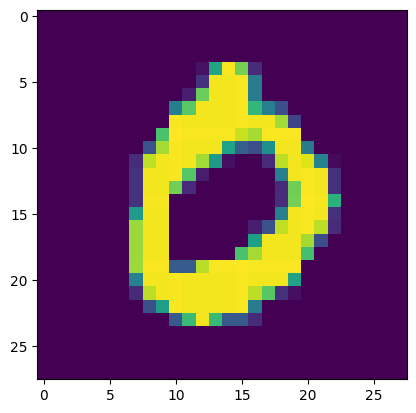

Prediction: 0


In [11]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

In [12]:
def add_pattern_bd(x, dataset='mnist', pattern_type='square', agent_idx=-1):
    """
    adds a trojan pattern to the image
    """
    x = np.array(x.squeeze())

    # if cifar is selected, we're doing a distributed backdoor attack (i.e., portions of trojan pattern is split between agents, only works for plus)
    if dataset == 'cifar10':
        if pattern_type == 'plus':
            start_idx = 5
            size = 6
            if agent_idx == -1:
                # vertical line
                for d in range(0, 3):
                    for i in range(start_idx, start_idx+size+1):
                        x[i, start_idx][d] = 0
                # horizontal line
                for d in range(0, 3):
                    for i in range(start_idx-size//2, start_idx+size//2 + 1):
                        x[start_idx+size//2, i][d] = 0
            else:# DBA attack
                #upper part of vertical
                if agent_idx % 4 == 0:
                    for d in range(0, 3):
                        for i in range(start_idx, start_idx+(size//2)+1):
                            x[i, start_idx][d] = 0

                #lower part of vertical
                elif agent_idx % 4 == 1:
                    for d in range(0, 3):
                        for i in range(start_idx+(size//2)+1, start_idx+size+1):
                            x[i, start_idx][d] = 0

                #left-part of horizontal
                elif agent_idx % 4 == 2:
                    for d in range(0, 3):
                        for i in range(start_idx-size//2, start_idx+size//4 + 1):
                            x[start_idx+size//2, i][d] = 0

                #right-part of horizontal
                elif agent_idx % 4 == 3:
                    for d in range(0, 3):
                        for i in range(start_idx-size//4+1, start_idx+size//2 + 1):
                            x[start_idx+size//2, i][d] = 0

    elif dataset == 'mnist':
        if pattern_type == 'square':
            if agent_idx == -1:
              for i in range(5, 7):
                  for j in range(6, 10):
                      x[i, j] = 255
            if agent_idx % 3 == 0:
              for i in range(5, 7):
                  for j in range(6, 8):
                      x[i, j] = 255

            if agent_idx % 3 == 1:
              for i in range(5, 7):
                  for j in range(8, 10):
                      x[i, j] = 255

            if agent_idx % 3 == 2:
              for i in range(5, 7):
                  for j in range(10, 12):
                      x[i, j] = 255

    elif dataset == 'fmnist':
        if pattern_type == 'square':
            for i in range(21, 26):
                for j in range(21, 26):
                    x[i, j] = 255

        elif pattern_type == 'plus':
            start_idx = 5
            size = 2
            if agent_idx == -1:
                # vertical line
                for i in range(start_idx, start_idx+size+1):
                    x[i, start_idx] = 255

                # horizontal line
                for i in range(start_idx-size//2, start_idx+size//2 + 1):
                    x[start_idx+size//2, i] = 255
            else:# DBA attack
                #upper part of vertical
                if agent_idx % 4 == 0:
                    for i in range(start_idx, start_idx+(size//2)+1):
                        x[i, start_idx] = 255

                #lower part of vertical
                elif agent_idx % 4 == 1:
                    for i in range(start_idx+(size//2), start_idx+size+1):
                        x[i, start_idx] = 255

                #left-part of horizontal
                elif agent_idx % 4 == 2:
                    for i in range(start_idx-size//2, start_idx+size//4+1):
                        x[start_idx+size//2, i] = 255

                #right-part of horizontal
                elif agent_idx % 4 == 3:
                    for i in range(start_idx-size//4, start_idx+size//2+1):
                        x[start_idx+size//2, i] = 255


    return x

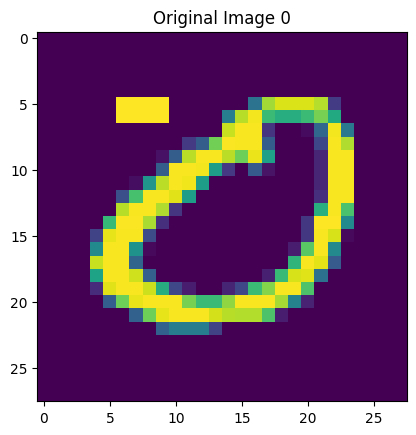

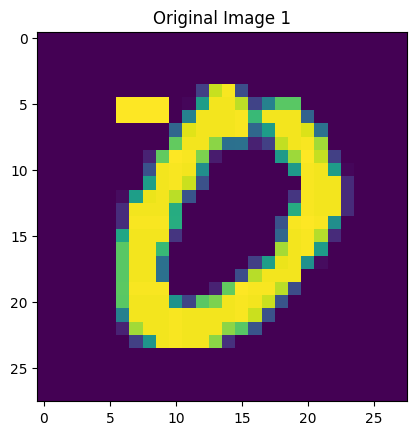

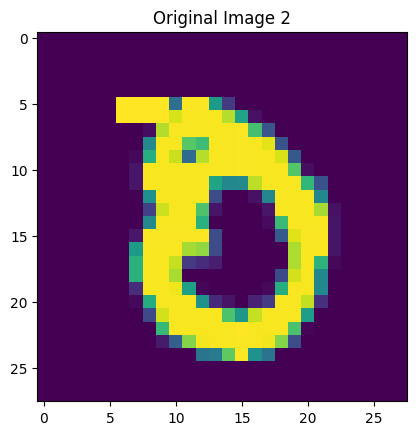

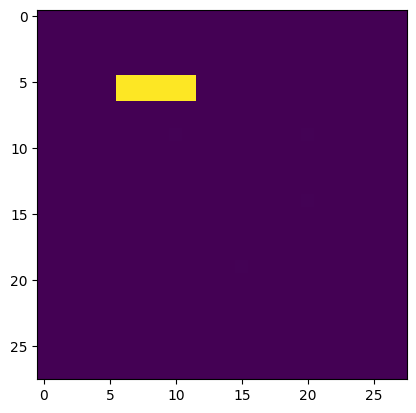

Prediction: 1

 Effectiveness of poison: 100.00%


In [13]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# # Display the first few original images
# for i in range(3):
#     plt.imshow(x_test[i].squeeze())
#     plt.title(f"Original Image {i}")
#     plt.show()


# Display the first few original images
for i in range(3):
    plt.imshow(poison_x_test[i].squeeze())
    plt.title(f"Original Image {i}")
    plt.show()

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 1 # image of the class to display



# Apply the poison pattern to each image in the test set
poison_x_test_with_pattern = np.array([add_pattern_bd(img) for img in x_test[is_poison_test]])

# Reshape the data to include the channel dimension
poison_x_test_with_pattern = poison_x_test_with_pattern.reshape(-1, 28, 28, 1)


# Use the modified test set in your existing code
poison_preds = np.argmax(classifier.predict(poison_x_test_with_pattern), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Rest of your code remains the same

# For displaying the image with the trigger pattern
c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i]
plt.imshow(poison_x_test_with_pattern[c_idx].squeeze())  # Use the poisoned dataset with pattern
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

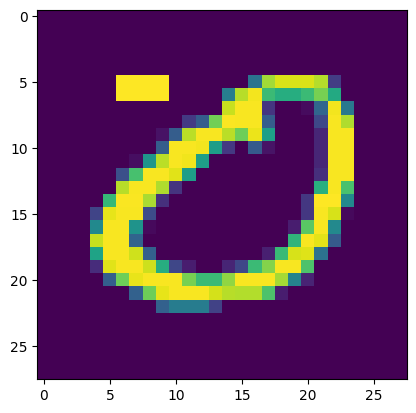

Prediction: 1

 Effectiveness of poison: 100.00%


In [16]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [17]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy: %.2f%%" % (total_acc * 100))


 Overall test set accuracy: 97.19%


<!-- # Detect Poison Using Activation Defence -->
<!-- ![image.png](attachment:image.png) -->

In [18]:
cleanse = NeuralCleanse(classifier)
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)

### Identifying the Backdoor

Unlike most defenses, part of the procedure for this defense is identifying exactly what the suspected backdoor is for each class. Below is the reverse-engineered backdoor. This will be appended to clean images to mimic backdoor behavior

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

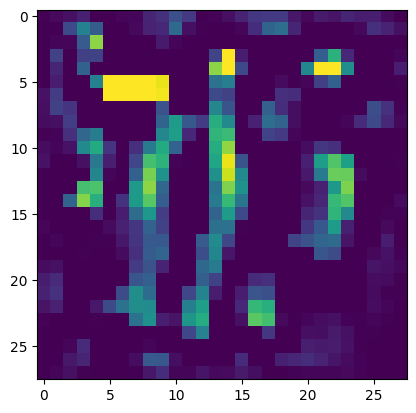

In [19]:
pattern, mask = defence_cleanse.generate_backdoor(x_test, y_test, np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))
plt.imshow(np.squeeze(mask * pattern))

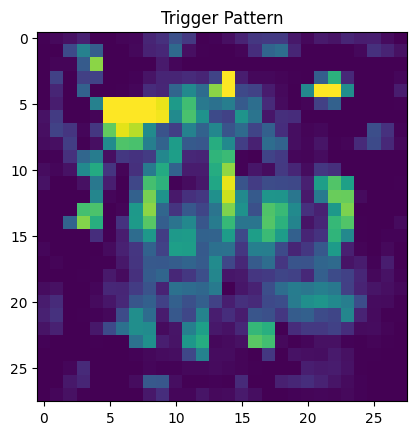

In [20]:
plt.imshow(np.squeeze(pattern))
plt.title("Trigger Pattern")
plt.show()


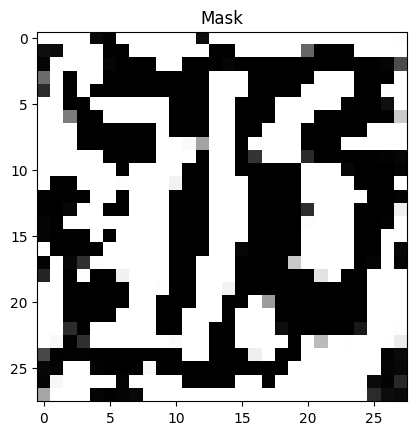

In [21]:
plt.imshow(np.squeeze(mask), cmap='gray')
plt.title("Mask")
plt.show()


Usually `generate_backdoor` is called as a result of calling `mitigate`. During this process, this defense generates a suspected backdoor for each class visualized above. The `mitigate` method also performs the mitigation  types presented below.

# Mitigation Types

There are different mitigation methods that are described below.

### Filtering

Filtering is the process of abstaining from potentially poisonous predictions at runtime. When this method is set, neurons are ranked by their association with the backdoor, and when neural activations are higher than normal, the classifier abstains from predication (output is all zeros).

In [ ]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["filtering"])

Generating backdoor for class 9: 100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


In [ ]:
poison_pred = defence_cleanse.predict(poison_x_test)
num_filtered = np.sum(np.all(poison_pred == np.zeros(10), axis=1))
num_poison = len(poison_pred)
effectiveness = float(num_filtered) / num_poison * 100
print("Filtered {}/{} poison samples ({:.2f}% effective)".format(num_filtered, num_poison, effectiveness))

Filtered 500/559 poison samples (89.45% effective)


### Unlearning

Unlearning is the process of retraining the backdoors with the correct label for one epoch. This works best for Trojan-style triggers that react to a specific neuron configuration.

In [ ]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["unlearning"])

Generating backdoor for class 9: 100%|██████████| 10/10 [01:10<00:00,  7.01s/it]

Epoch 1/1
   5/4129 [..............................] - ETA: 1:03 - loss: 2.7731 - acc: 0.6000    

4129/4129 [==============================] - 70s 17ms/step - loss: 0.0115 - acc: 0.9981


In [ ]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after unlearning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after unlearning: 5.19% (previously 100.00%)

 Clean test set accuracy: 54.14% (previously 96.47%)


### Pruning

Pruning is the process of zero-ing out neurons strongly associated with backdoor behavior until the backdoor is ineffective or 30% of all neurons have been pruned. Be careful as this can negatively affect the accuracy of your model. This works best for fully mitigating the effects of backdoor poisoning attacks.

In [ ]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning"])

Generating backdoor for class 9: 100%|██████████| 10/10 [01:10<00:00,  7.02s/it]


In [ ]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after pruning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after pruning: 0.00% (previously 100.00%)

 Clean test set accuracy: 46.46% (previously 96.47%)


### Combination

Finally, you can also do a combination of any of the above mitigation methods to fit your needs. Just add those types to the `mitigation_types` list.

In [ ]:
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning", "filtering"])

Generating backdoor for class 9: 100%|██████████| 10/10 [01:10<00:00,  7.09s/it]
